In [23]:
############# Loading ##############

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

# Evaluation metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

epsoln = 1e-9  # Define a small epsilon value for division by zero cases

def rmse(y_true, y_pred):
  return np.sqrt(mse(y_true, y_pred))

def pbe(y_true, y_pred):
  if np.sum(y_true)!=0:
    return 100*(np.sum(y_pred - y_true)/np.sum(y_true))
  else:
    return 100*(np.sum(y_pred - y_true)/(np.sum(y_true)+epsoln))

def pocid(y_true, y_pred):
  n = len(y_true)
  D = [1 if (y_pred[i] - y_pred[i-1]) * (y_true[i] - y_true[i-1]) > 0 else 0 for i in range(1, n)]
  POCID = 100 * np.sum(D) / (n-1)
  return POCID

def mcpm(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

def znorm(x):
  if np.std(x) != 0: 
      x_znorm = (x - np.mean(x)) / np.std(x)
  else:
      x_znorm = (x - np.mean(x)) / (np.std(x) + epsoln)
  return x_znorm

def znorm_reverse(x, mean_x, std_x):
  x_denormalized = (np.array(x) * std_x) + mean_x
  return x_denormalized

def get_stats_norm(series, horizon, window):
  last_subsequence = series[-(horizon+window):-horizon].values
  last_mean = np.mean(last_subsequence)
  last_std = np.std(last_subsequence)
  return last_mean, last_std

# Em geral, considera-se um tamanho de janela capaz de capturar um ciclo dos dados
# Por exemplo, 12 observações no caso dos dados com frequência mensal
def rolling_window(series, window):
  data = []
  for i in range(len(series)-window):
    example = znorm(np.array(series[i:i+window+1]))
    data.append(example)
  df = pd.DataFrame(data)
  return df

# Para predição de vendas por UF (mensal), será considerado horizon = 12
# Para predição de vendas por município (anual), será considerado horizon = 1
def train_test_split(data, horizon):
  X = data.iloc[:,:-1] # features
  y = data.iloc[:,-1] # target

  X_train = X[:-horizon] # features train
  X_test =  X[-horizon:] # features test

  y_train = y[:-horizon] # target train
  y_test = y[-horizon:] # target test
  return X_train, X_test, y_train, y_test

def recursive_multistep_forecasting(X_test, model, horizon):
  # example é composto pelas últimas observações vistas
  # na prática, é o pbeprimeiro exemplo do conjunto de teste
  example = X_test.iloc[0].values.reshape(1,-1)

  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    # Descartar o valor da primeira posição do vetor de características
    example = example[:,1:]

    # Adicionar o valor predito na última posição do vetor de características
    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def baseline_mean(series, horizon):
  # como as séries são normalizadas, esse baseline irá retornar uma reta próxima de zero
  pred = np.repeat(np.mean(znorm(series[:-horizon])), horizon)
  return pred

def baseline_persistent(series, horizon):
  return np.repeat(znorm(series[-2*horizon:-horizon]).values[-1], horizon)

def baseline_persistent_window(series, horizon):
  subsequence = znorm(series[-horizon*2:-horizon]).values
  return subsequence


In [24]:
######### Lista Estados ##############

import os
import csv

def extract_estado(file_name):
    # Split the file name by underscores
    parts = file_name.split('_')
    # Extract the name between underscores
    estado = parts[1]
    return estado

def read_csv_files(folder_path):
    estados = []
    # List all files in the folder
    files = os.listdir(folder_path)
    # Iterate through each file
    for file_name in files:
        # Check if it's a CSV file
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            # Open the CSV file and read the data
            with open(file_path, 'r', newline='') as csvfile:
                reader = csv.reader(csvfile)
                # Assuming the first row contains headers
                headers = next(reader)
                # Extract estado from file name and append to estados list
                estado = extract_estado(file_name)
                estados.append(estado)
                estados.sort()
    return estados

# Specify the folder path where CSV files are located


In [19]:
######### Regressors #######################

products = sorted([name for name in os.listdir('./uf') if os.path.isdir(os.path.join('./uf', name))])

horizon = 12
window = 12

for product in products:
    folder_path = f'./uf/{product}/'
    # Read the CSV files and extract estado names
    estados = read_csv_files(folder_path)
    
    for estado in estados:
    
        # carregamento do arquivo
        df = pd.read_csv(f"./uf/{product}/mensal_{estado}_{product}.csv", header=0, sep=";")
    
        series = df["m3"]
    
        # Parâmetros
        # - horizon: horizonte de predição >> Padrão 12
        # - window: comprimento da janela para a geração da tabela atributo-valor >> Padrão 12
    
        # Geração da tabela atributo-valor (normalizado)
        data = rolling_window(series, window)
    
        # Divisão dos dados em treino/teste considerando o horizonte de predição de 12 meses
        X_train, X_test, y_train, y_test = train_test_split(data, horizon)
    
        ############################################# lgb
        num_round = 100
    
        # Convert data to LightGBM dataset format
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)
    
        ############################################
    
        ############## Regressores ##################
        # regr1 = LinearRegression()
        regr2 = KNeighborsRegressor(n_neighbors = 3)
        regr3 = XGBRegressor()
        regr4 = SVR(kernel='rbf')
        regr5 = RandomForestRegressor()
        # regr6 = MLPRegressor(random_state=1, activation='relu', max_iter=500)
        regr7 = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                                num_leaves=31, learning_rate=0.05, feature_fraction=0.9,
                                bagging_fraction=0.8, bagging_freq=5, verbose=-1)
        
        # Treinamento dos modelos
        # regr1.fit(X_train, y_train)
        # predictions1a = recursive_multistep_forecasting(X_test, regr1, horizon)
        regr2.fit(X_train, y_train)
        predictions2a = recursive_multistep_forecasting(X_test, regr2, horizon)
        regr3.fit(X_train, y_train)
        predictions3a = recursive_multistep_forecasting(X_test, regr3, horizon)
        regr4.fit(X_train, y_train)
        predictions4a = recursive_multistep_forecasting(X_test, regr4, horizon)
        regr5.fit(X_train, y_train)
        predictions5a = recursive_multistep_forecasting(X_test, regr5, horizon)
        # regr6.fit(X_train, y_train)
        # predictions6a = recursive_multistep_forecasting(X_test, regr6, horizon)
        regr7.fit(X_train, y_train)
        predictions7a = recursive_multistep_forecasting(X_test, regr7, horizon)
    
        # Recupera a média e desvio-padrão da última subsequência observada
        mean_norm, std_norm = get_stats_norm(series, horizon, window)

        # Reescala a predição
        # predictions1 = znorm_reverse(predictions1a, mean_norm, std_norm)
        predictions2 = znorm_reverse(predictions2a, mean_norm, std_norm)
        predictions3 = znorm_reverse(predictions3a, mean_norm, std_norm)
        predictions4 = znorm_reverse(predictions4a, mean_norm, std_norm)
        predictions5 = znorm_reverse(predictions5a, mean_norm, std_norm)
        # predictions6 = znorm_reverse(predictions6a, mean_norm, std_norm)
        predictions7 = znorm_reverse(predictions7a, mean_norm, std_norm)

        Valores_Reais = series.tail(12)
        Valores_Reais = Valores_Reais.reset_index(drop=True)
    
        # mape_result1 = mape(Valores_Reais, predictions1)
        mape_result2 = mape(Valores_Reais, predictions2)
        mape_result3 = mape(Valores_Reais, predictions3)
        mape_result4 = mape(Valores_Reais, predictions4)
        mape_result5 = mape(Valores_Reais, predictions5)
        # mape_result6 = mape(Valores_Reais, predictions6)
        mape_result7 = mape(Valores_Reais, predictions7)
    
        # pbe_result1 = pbe(Valores_Reais, predictions1)
        pbe_result2 = pbe(Valores_Reais, predictions2)
        pbe_result3 = pbe(Valores_Reais, predictions3)
        pbe_result4 = pbe(Valores_Reais, predictions4)
        pbe_result5 = pbe(Valores_Reais, predictions5)
        # pbe_result6 = pbe(Valores_Reais, predictions6)
        pbe_result7 = pbe(Valores_Reais, predictions7)
    
        # pocid_result1 = pocid(Valores_Reais, predictions1)
        pocid_result2 = pocid(Valores_Reais, predictions2)
        pocid_result3 = pocid(Valores_Reais, predictions3)
        pocid_result4 = pocid(Valores_Reais, predictions4)
        pocid_result5 = pocid(Valores_Reais, predictions5)
        # pocid_result6 = pocid(Valores_Reais, predictions6)
        pocid_result7 = pocid(Valores_Reais, predictions7)
    # 
        # predictions1b = ', '.join(f"{item:f}" for item in predictions1)
        predictions2b = ', '.join(f"{item:f}" for item in predictions2)
        predictions3b = ', '.join(f"{item:f}" for item in predictions3)
        predictions4b = ', '.join(f"{item:f}" for item in predictions4)
        predictions5b = ', '.join(f"{item:f}" for item in predictions5)
        # predictions6b = ', '.join(f"{item:f}" for item in predictions6)
        predictions7b = ', '.join(f"{item:f}" for item in predictions7)

            
        rows_data = [
            # [product,estado,'LR',fd1,mape_result1,pocid_result1,pbe_result1,p1],
            [product,estado,'kNN',mape_result2,pocid_result2,pbe_result2,predictions2b],
            [product,estado,'XGB',mape_result3,pocid_result3,pbe_result3,predictions3b],
            [product,estado,'SVR',mape_result4,pocid_result4,pbe_result4,predictions4b],
            [product,estado,'RF',mape_result5,pocid_result5,pbe_result5,predictions5b],
            # [product,estado,'MLP',fd6,mape_result6,pocid_result6,pbe_result6,p6],
            [product,estado,'LGB',mape_result7,pocid_result7,pbe_result7,predictions7b]             
        ]
        

        
        # CSV Output VALORES REAIS
        with open(f'RawData_{window}_norm_output.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            for row_data in rows_data:
                writer.writerow(row_data)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the p

KeyboardInterrupt: 

In [12]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.566555,0.342247,-0.900377,0.340331,-0.403334,-1.266859,-0.484794,-1.219848,-0.082971,-0.366478,0.636824,0.083527,2.755178
1,0.391888,-0.867635,0.389945,-0.363833,-1.239101,-0.446400,-1.191450,-0.039114,-0.326476,0.690470,0.129648,2.837630,0.034428
2,-0.795024,0.459652,-0.292386,-1.165633,-0.374762,-1.118093,0.031584,-0.255115,0.759483,0.199956,2.901686,0.104955,-0.456303
3,0.325796,-0.425596,-1.298094,-0.507902,-1.250595,-0.101904,-0.388357,0.625370,0.066324,2.765737,-0.028596,-0.589373,0.807190
4,-0.484264,-1.280340,-0.559360,-1.237001,-0.188923,-0.450286,0.474650,-0.035430,2.427544,-0.122036,-0.633695,0.640544,1.448597
...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0.499713,-0.913126,2.596040,0.055203,-0.037721,0.725346,-1.064844,1.151521,-0.895235,-0.659271,-0.096895,-0.767842,-0.592890
394,-0.845094,2.681146,0.127947,0.034570,0.801350,-0.997550,1.229599,-0.827116,-0.590004,-0.024892,-0.699103,-0.523300,-0.367552
395,2.068131,-0.112604,-0.192359,0.462562,-1.073912,0.828337,-0.928341,-0.725820,-0.243146,-0.819003,-0.668846,-0.535819,1.940821
396,0.040887,-0.057874,0.753123,-1.149512,1.206067,-0.969250,-0.718465,-0.120765,-0.833855,-0.647914,-0.483184,2.583669,0.397074


(-2.0, 2.0)

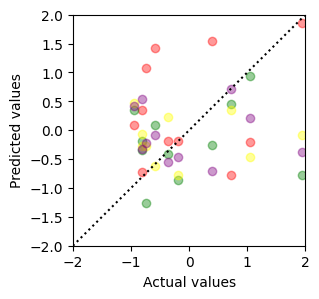

In [13]:
plt.figure(figsize=(3,3))
# plt.scatter(y_test.values, predictions1a, alpha=0.4)
plt.scatter(y_test.values, predictions2a, alpha=0.4, color='red')
plt.scatter(y_test.values, predictions3a, alpha=0.4, color='green')
plt.scatter(y_test.values, predictions4a, alpha=0.4, color='yellow')
plt.scatter(y_test.values, predictions5a, alpha=0.4, color='purple')
# plt.scatter(y_test.values, predictions6a, alpha=0.4, color='orange')
# plt.scatter(y_test.values, preds_baseline1, alpha=0.4, color='blue')
# plt.scatter(y_test.values, preds_baseline2, alpha=0.4, color='gray')
# plt.scatter(y_test.values, preds_baseline3, alpha=0.4, color='black')
plt.axline((0, 0), slope=1, linestyle='dotted', color='black')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.xlim([-2, 2])
plt.ylim([-2, 2])